In [78]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm
from customDataset import FerrisAndBearsDataset as fb

In [79]:
# Variables
CUDA = False
batch_size = 128
img_chnl = 3
z = 100
hidden = 64
x = 64
epochs = 1000
lr = 2e-4
seed = 1

In [80]:
# Establish Device
CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 1.13.0


In [81]:
# Import Custom Dataset and Preproccess 
dataset = fb(csv_file = 'descrim_bears.csv', root_dir = './Bears', transform = transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,)),
                     ]))
train_set = dataset
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

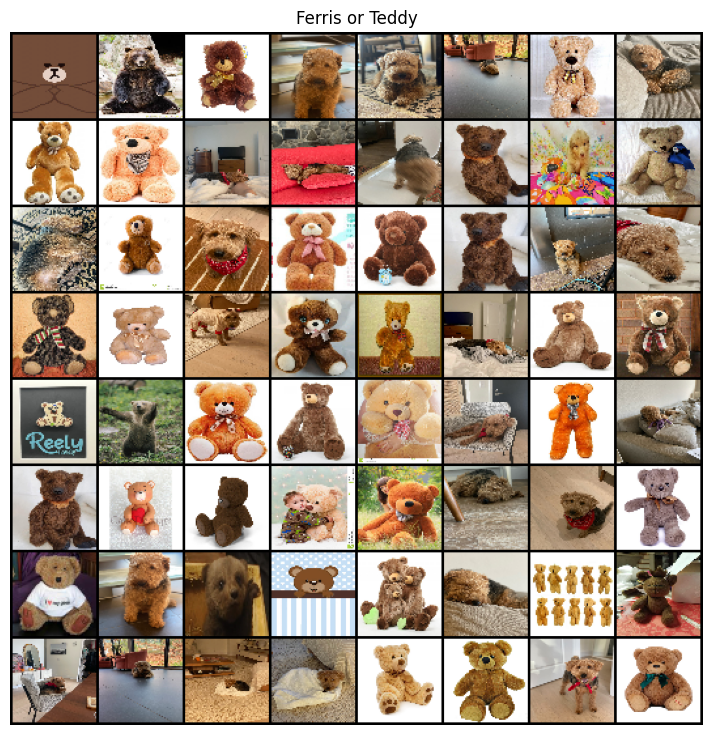

In [82]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(9,9))
plt.axis("off")
plt.title("Ferris or Teddy")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [83]:
# Write Descriminator Network in Standard DCGAN for LSUN form
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_chnl, hidden, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden, hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 2, hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 4, hidden * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [84]:
# Write Generator Network in Standard DCGAN for LSUN form
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z, hidden * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hidden * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 8, hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 4, hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden * 2, hidden, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden, img_chnl, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [87]:
descriminator = torch.load('./descriminator_checkpoint5')

In [92]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

results = descriminator(images)
output = descriminator(images.detach()).view(-1)
#output = torch.sigmoid(output)
output = torch.round(output)
output = output.detach().numpy()
labels = labels.detach().numpy()

welshie_corr = 0 
welshie_incorr = 0 
total_welshie = 0 
bear_corr = 0 
bear_incorr = 0 
total_bear = 0 
for i in range(len(output)): 
    if labels[i] == 1: 
        if output[i] == 1: 
            welshie_corr += 1 
        if output[i] == 0: 
            welshie_incorr += 1
        total_welshie += 1 
    if labels[i] == 0: 
        if output[i] == 0: 
            bear_corr += 1 
        if output[i] == 1: 
            bear_incorr += 1
        total_bear += 1
print("TOTAL CORRECT:", (welshie_corr+bear_corr)/(total_welshie+total_bear)) 
print("TOTAL FERRIS CORRECT:", welshie_corr/total_welshie) 
print("TOTAL BEAR CORRECT:", bear_corr/total_bear)

TOTAL CORRECT: 0.9921875
TOTAL FERRIS CORRECT: 1.0
TOTAL BEAR CORRECT: 0.984375
